In [ ]:
!unzip /content/DataDrivenAcceleration-XJ.zip -d /content/DataDrivenAcceleration-XJ
%cd /content/DataDrivenAcceleration-XJ

Archive:  /content/DataDrivenAcceleration-XJ.zip
  inflating: /content/DataDrivenAcceleration-XJ/.gitignore  
   creating: /content/DataDrivenAcceleration-XJ/.idea/
  inflating: /content/DataDrivenAcceleration-XJ/.idea/.gitignore  
  inflating: /content/DataDrivenAcceleration-XJ/.idea/DataDrivenAcceleration.iml  
   creating: /content/DataDrivenAcceleration-XJ/.idea/inspectionProfiles/
  inflating: /content/DataDrivenAcceleration-XJ/.idea/inspectionProfiles/profiles_settings.xml  
  inflating: /content/DataDrivenAcceleration-XJ/.idea/misc.xml  
  inflating: /content/DataDrivenAcceleration-XJ/.idea/modules.xml  
  inflating: /content/DataDrivenAcceleration-XJ/.idea/vcs.xml  
   creating: /content/DataDrivenAcceleration-XJ/AADL/
  inflating: /content/DataDrivenAcceleration-XJ/AADL/__init__.py  
  inflating: /content/DataDrivenAcceleration-XJ/AADL/accelerate.py  
  inflating: /content/DataDrivenAcceleration-XJ/AADL/anderson_acceleration.py  
   creating: /content/DataDrivenAcceleration-XJ

In [ ]:
import time
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn 

from src.NN_models import *
from src.anderson_acceleration import *
from src.Phi import *
from src.utils import count_parameters

import AADL as AADL

## Problem Setup

Consider Helmholtz Equation

$$ -\Delta u + u^3 = f         $$


assume the solution to the problem is given as

$$ u = \sum_{k=1}^{3} \text{sin}kx_1 \text{sin}kx_2 \dots \text{sin}kx_d$$

In [ ]:
def data_gen(x):
    # solution to burgers equation
    d = x.shape[1]
    xx1 = torch.sin(x)
    xx2 = torch.sin(2*x)
    xx3 = torch.sin(3*x)
    sol = torch.prod(xx1, dim=1).view(-1,1) + torch.prod(xx3, dim=1).view(-1,1) + torch.prod(xx3, dim=1).view(-1,1)

    return sol

def forcing(x):
    # forcing term for the burgers equation
    d = x.shape[1]
    u = data_gen(x)


    # laplacian 
    lap = d * torch.prod(torch.sin(x), dim=1).view(-1,1) + 4*d*torch.prod(torch.sin(2*x), dim=1).view(-1,1) + 9*d*torch.prod(torch.sin(3*x), dim=1).view(-1,1)

    f = -lap + u**3

    return f



In [ ]:
# define a test problem
def loss_helmholtz(x, y, x_to_train_f, d, net):
    '''
    :param x: input for boundary condition
    :param y: boundary data
    :param x_to_train_f: input for calculating PDE loss
    :param d: number of dimension
    :param net: network
    :return:  loss
    '''

    ### u_t + u*u_x1 + u^2*u_x2 + ... + u^d*u_xd = 0 with boundary and initial condition
    loss_fun = nn.MSELoss() 
    loss_BC = loss_fun(net.forward(x), y)

    g = x_to_train_f.clone()
    g.requires_grad = True
    
    u = net.forward(g)
    # gradient
    u_x = autograd.grad(u, g, torch.ones([x_to_train_f.shape[0], 1]).to(g.device), retain_graph=True, create_graph=True)[0]

    # laplacian? depending on the problem
    num = x_to_train_f.shape[0]
    lap = torch.zeros(num,1).to(g.device)
    for i in range(d-1):
        vec = torch.zeros_like(u_x)
        vec[:,i] = torch.ones(num)
        u_xx_i = autograd.grad(u_x, g, vec, create_graph=True)[0]
        u_xxi = u_xx_i[:, [i]]

        lap = lap + u_xxi

    f = -lap + u**3

    ## forcing term
    ff = forcing(g)


    loss_PDE = loss_fun(f, ff)
    loss = loss_BC + loss_PDE
 

    res_PDE = f - ff
    res_BC = net.forward(x) - y
    res = torch.cat((res_PDE, res_BC), dim=0)
    res = torch.flatten(res)


    return res, loss





In [ ]:
class ResNN_fun(nn.Module):
    def __init__(self, d, m, nTh=2):
        """
            ResNet N portion of Phi
        :param d:   int, dimension of space input
        :param m:   int, hidden dimension
        :param nTh: int, number of resNet layers , (number of theta layers)
        """
        super().__init__()

        if nTh < 2:
            print("nTh must be an integer >= 2")
            exit(1)

        self.d = d
        self.m = m
        self.nTh = nTh
        self.layers = nn.ModuleList([])
        self.layers.append(nn.Linear(d, m, bias=True)) # opening layer
        self.layers.append(nn.Linear(m,m, bias=True)) # resnet layers
        for i in range(nTh-2):
            self.layers.append(copy.deepcopy(self.layers[1]))
        self.layers.append(nn.Linear(m,1, bias=True))
        self.act = antiderivTanh
        self.h = 1.0 / (self.nTh-1) # step size for the ResNet

    def forward(self, x):
        """
            N(s;theta). the forward propogation of the ResNet
        :param x: tensor nex-by-d, inputs
        :return:  tensor nex-by-m,   outputs
        """

        x = self.act(self.layers[0].forward(x))

        for i in range(1,self.nTh):
            x = x + self.h * self.act(self.layers[i](x))

        x = self.layers[-1](x)

        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

# parameter list
N_u = 400
N_f = 4000
niters = 3000
lr = 0.01
print_freq = 100


d = 10

start_time = time.time() 
print((2 * "%7s    ") % ("step", "Loss"))
err_average = 0.

record = np.zeros([niters+1, 5])
for repeat in range(5):
    x = torch.rand(N_u,d).to(device)
    y = data_gen(x); y = y.to(device)
    x_to_train_f = torch.rand(N_f,d).to(device)

    x_val = torch.rand(2048,d).to(device)
    y_val = data_gen(x_val); y_Val = y_val.to(device)

    # layers = np.array([d, 20, 40, 40, 20, 1])
    # net = MLP(layers)
    net = ResNN_fun(d=d, m=32, nTh=4)
    net.to(device)
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    # accelerate(optim, frequency = 10)
    # AADL.accelerate(optim, relaxation=1.0, store_each_nth=10, frequency=10)
    record[0,repeat] = loss_helmholtz(x, y, x_to_train_f, d, net)[1].detach()
    print('Initial validation results, error in absolute value: ', torch.mean(torch.abs(y_val - net(x_val))))

    for itr in range(1, niters + 1):
        def closure():
            optim.zero_grad()
            res, loss = loss_helmholtz(x, y, x_to_train_f, d, net)
            loss.backward()
            return res, loss
        optim.step(closure)
        loss = loss_helmholtz(x, y, x_to_train_f, d, net)[1]
        record[itr, repeat] = loss.detach()

        if itr % print_freq == 0:
            print(("%06d    " + "%1.4e    ") %(itr, loss))

        # resample
        if itr % 500 == 0:
            x = torch.rand(N_u,d).to(device)
            y = data_gen(x); y = y.to(device)
            x_to_train_f = torch.rand(N_f,d).to(device)
            # clear_hist(optim)

        # change learning rate
        if itr % 1000 == 0:
            for p in optim.param_groups:
                p['lr'] *= 0.2

    # Validation
    err = torch.mean(torch.abs(y_val - net(x_val)))
    err_average += err
    print('Validation results, error in absolute value: ', err)

print('average validation error: ', err_average/5)
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

device:  cuda
   step       Loss    
Initial validation results, error in absolute value:  tensor(1.1471, device='cuda:0', grad_fn=<MeanBackward0>)
000100    2.1007e+01    
000200    1.4814e+01    
000300    3.1312e+00    
000400    2.1906e+00    
000500    1.6400e+00    
000600    1.3864e+00    
000700    1.4331e+00    
000800    1.1336e+00    
000900    1.0850e+00    
001000    9.8910e-01    
001100    1.2305e+00    
001200    1.1810e+00    
001300    1.1435e+00    
001400    1.1114e+00    
001500    1.0829e+00    
001600    1.0867e+00    
001700    1.0559e+00    
001800    1.0319e+00    
001900    1.0108e+00    
002000    9.9144e-01    
002100    1.0277e+00    
002200    1.0078e+00    
002300    9.9631e-01    
002400    9.8702e-01    
002500    9.7875e-01    
002600    9.3391e-01    
002700    9.1461e-01    
002800    9.0242e-01    
002900    8.9204e-01    
003000    8.8244e-01    
Validation results, error in absolute value:  tensor(0.1028, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
record0 = record

In [ ]:
record_accelerated = record

In [ ]:
record_AADL = record

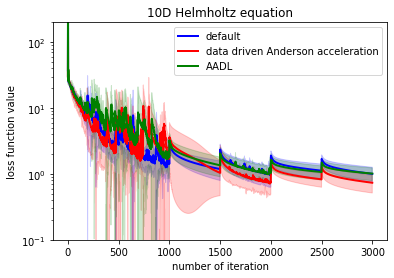

In [ ]:
import matplotlib.pyplot as plt

anderson_avg = np.mean(record_accelerated,axis=1)
anderson_std = np.std(record_accelerated,axis=1)
avg = np.mean(record0,axis=1)
std = np.std(record0,axis=1)

fig = plt.figure()
plt.plot(range(niters+1),avg, color='b', linewidth=2)
plt.fill_between(range(niters+1), avg-std,avg+std,color='b',alpha=.2)
plt.plot(range(niters+1),anderson_avg, color='r', linewidth=2)
plt.fill_between(range(niters+1), anderson_avg-anderson_std,anderson_avg+anderson_std,color='r',alpha=.2)


AADL_avg = np.mean(record_AADL,axis=1)
AADL_std = np.std(record_AADL,axis=1)
plt.plot(range(niters+1),AADL_avg, color='g', linewidth=2)
plt.fill_between(range(niters+1), AADL_avg-AADL_std,AADL_avg+AADL_std,color='g',alpha=.2)


plt.yscale('log')
plt.ylim([1.e-1, 2.e2])
plt.legend(['default', 'data driven Anderson acceleration', 'AADL'])
plt.xlabel('number of iteration')
plt.ylabel('loss function value')
plt.title('10D Helmholtz equation')
fig.savefig('file.jpg', dpi=500)

In [ ]:
from google.colab import files
files.download('file.jpg') 